# CLIMADA - SVI data flow: EXAMPLE 1

### Using SVI Data for Impact Analysis

In this example, we use pre-labeled Social Vulnerability Index (SVI) data to look at the impact of different population groups belongning to different vulnerability groups in Ireland.

**Extracting Population Data**

Population counts are extracted from census data to quantify exposure and assess how different vulnerability groups are impacted.

**Approaches to use SVI Data**

1. **Segmented Analysis**: Analyze how different vulnerability groups are impacted by hazards.
2. **Customized Impact Functions**: In future examples, we could potentially assign different impact functions to these groups based on their vulnerability levels.

**Pre-Labeled SVI Data**

The SVI data has been pre-labeled using methods from [this GitHub repository](https://github.com/jamesfitton/ISVEHI/tree/main/0_Scripts), based on census data.

**Future Steps: MCDM**

We'll later use Multi-Criteria Decision Making (MCDM) to assign different weights to these groups for a more detailed impact analysis.


In [1]:
from pathlib import Path

**Define the path to DATA folder. The DATA can be downloaded from NEXTCLOUD [https://cloud.tu-braunschweig.de/f/569399210](https://cloud.tu-braunschweig.de/f/569399210)**   

In [2]:
data_path = Path('/Users/vwattin/Documents/Programming/Climate/DIRECTED/Coupling/DATA')

# Define the output folder path (used later in the script)
output_path = Path('Results/SVI')

# Create the output folder if it doesn't exist
output_path.mkdir(parents=True, exist_ok=True)

### Exposure data

Load the shape file of the geographic areas

In [3]:
import numpy as np
import geopandas as gpd

# Parameters
folder = 'SVI/Small_Areas_Ungeneralised_-8569847655562501507'
file = 'Small_Areas_Ungen_-_2015.shp'

# Folder where the file is located
shape_file = data_path / folder / file

# Load the shapefile into a GeoDataFrame
exp_gdf = gpd.read_file(shape_file)

# The object stores the following columns
# ['GUID', 'NUTS1', 'NUTS1NAME', 'NUTS2', 'NUTS2NAME', 'NUTS3',
#        'NUTS3NAME', 'COUNTY', 'COUNTYNAME', 'CSOED', 'OSIED', 'EDNAME',
#        'SA_PUB2011', 'SMALL_AREA', 'GEOGID', 'AREA', 'CHANGECODE', 'ESRI_OID',
#        'geometry']

# Print the first row of the GeoDataFrame
# print(exp_gdf.iloc[0])

# Store only the columns that are needed
store_columns = ['GUID', 'NUTS1', 'NUTS1NAME', 'COUNTY', 'COUNTYNAME', 'geometry']
exp_gdf = exp_gdf[store_columns]

Add additonal census data to the gdf

In [4]:
import pandas as pd
from climada.entity import Exposures

# Parameters
folder = 'SVI'
file = 'censusData.csv'
file_path = data_path / folder / file

# Import CSV file as a DataFrame
census_df = pd.read_csv(file_path)

# The available columns in the DataFrame are
# ['GUID', 'populationTotal', 'young', 'old', 'priSch', 'poorHealth',
#        'disability', 'unemploy', 'lowSkill', 'farming', 'rent', 'education',
#        'engLang', 'newRes', 'travelTime', 'householdsTotal', 'noHeating',
#        'yearBuilt', 'mobHome', 'oneParent', 'onePerson', 'noCar', 'noInternet',
#        'priWater']

# Store only the columns that are needed
store_columns = ['GUID','populationTotal']
census_df = census_df[store_columns]

# Ensure the GUID column is of the same type in both DataFrames
census_df['GUID'] = census_df['GUID'].astype(str)
exp_gdf['GUID'] = exp_gdf['GUID'].astype(str)

# Merge the two DataFrames
exp_gdf = exp_gdf.merge(census_df, on='GUID')

# Print the first row of the GeoDataFrame
# print(exp_gdf.iloc[0])

Add the social vulnerability index to the gdf

In [5]:
import pandas as pd

# Parameters
folder = 'SVI'
file = 'irelandVulnerability.csv'
file_path = data_path / folder / file

# Import CSV file as a DataFrame
svi_vuln_df = pd.read_csv(file_path)

# Store only the columns that are needed
store_columns = ['GUID','vuln']
svi_vuln_df = svi_vuln_df[store_columns]

# Get the 6 equal intervals of the column vuln and store them in a new column called vuln_str [ 'Very Low', 'Low', 'Average', 'High', 'Very High', 'Extreme']
vuln_bins = ['Very Low', 'Low', 'Average', 'High', 'Very High', 'Extreme']
svi_vuln_df['vuln_group'] = pd.cut(svi_vuln_df['vuln'], bins=len(vuln_bins), labels=vuln_bins)

# Ensure the GUID column is of the same type in both DataFrames
#census_df['GUID'] = census_df['GUID'].astype(str)
exp_gdf['GUID'] = svi_vuln_df['GUID'].astype(str)

# Join the GeoDataFrame with the census DataFrame on the GUID column
exp_gdf = exp_gdf.merge(svi_vuln_df, on='GUID')

# Print the first 5 rows of the merged GeoDataFrame
# print(exp_gdf.head())

Create Exposure Files for Each Vulnerability Group (Including All Groups)

*Note: This approach may not be the most efficient, as we could derive the exposure and impact objects for one exposure and then use the vulnerability labels to calculate values for each group from the impact matrix. However, for simplicity and to separate the return period calculations, we will follow this method in the example notebook.*


In [6]:
from climada.entity import Exposures

# Parameters
intended_crs = "EPSG:4326"  # CLIMADA default CRS

# Assign the populationTotal column as the value column in the Exposure DataFrame
exp_gdf['value'] = exp_gdf['populationTotal']

# Check the CRS (Coordinate Reference System)
print("Origin CRS:", exp_gdf.crs)
exp_gdf = exp_gdf.to_crs(intended_crs) # Convert the crs to the intended crs

# Store the exposure object in the dictionary for each vulnerability group
exp_dict = {}  # Initialize an empty dictionary to store exposure objects
exp_dict['All'] = Exposures(exp_gdf)  # All vulnerability groups
exp_dict.update({vuln_group: Exposures(exp_gdf[exp_gdf['vuln_group'] == vuln_group]) for vuln_group in vuln_bins})

Origin CRS: EPSG:2157


### Hazard data

Load the hazard dataset – wind storm data using the CLIMADA 

In [7]:
from climada.util.api_client import Client
client = Client()

In [8]:
haz = client.get_hazard(
    hazard_type='storm_europe',
    properties={
        'climate_scenario':'ssp585',
        'spatial_coverage':'Europe',
        'data_source':'CMIP6',
        'gcm':'CMCC-ESM2'
    }
)

haz.check()

###  Impact function set

Then, we define an impact function. This is tricky, as this typically depends strongly on the datasets, and the user should define them carefully. Here we simply assume a 1m threshold.

<Axes: title={'center': 'WS 1: '}, xlabel='Intensity ()', ylabel='Impact (%)'>

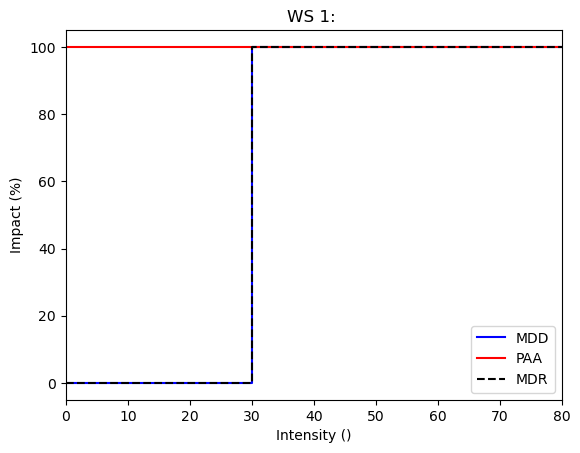

In [9]:
from climada.entity import ImpactFunc, ImpactFuncSet
min_wind = 0
max_wind = 80

threshold1 = 30
impf_id1 = 1
impf1 = ImpactFunc.from_step_impf(
    intensity=(min_wind, threshold1, max_wind),
    haz_type=haz.haz_type,
    impf_id=impf_id1
)

impfset = ImpactFuncSet([impf1])

# Plot the impact function, which is a step function
impfset.plot()

We need to assign the impact functions to the exposure points (We could potnetially assign different vulnerability impact functions to different groups)

In [10]:
# Store the impact function set in the dictionary for each vulnerability group (including 'All')
for _, exp in exp_dict.items():    
    exp.gdf[f'impf_{haz.haz_type}'] = impf_id1


#### Calculate the impact - Rasterization

1. **Rasterization Approach**:
   - Divide each building into grid points.
   - Distribute the building’s value equally among these grid points.
   - Use a nearest-neighbor approach (with a specified distance tolerance) to calculate the impact.
   - See CLIMADA tutorial [how-to-use-polygons-or-lines-as-exposure](https://climada-python.readthedocs.io/en/stable/tutorial/climada_entity_Exposures_polygons_lines.html#how-to-use-polygons-or-lines-as-exposure)

In [11]:
import climada.util.lines_polys_handler as u_lp

# Initialize an empty dictionary to store the impact for each vulnerability group
imp_dict = {}

# Calculate the geometric impact for each vulnerability group (including 'All')
for vuln_group, exp in exp_dict.items():
    imp_dict[vuln_group] = u_lp.calc_geom_impact(
        exp=exp, # Exposure object
        impf_set=impfset, # Impact function set
        haz=haz, # hazard object
        res= 1000, # Resolution of the grid in meters (Don't know the max resolution) :/)
        to_meters=True, # If True, res is interpreted as meters
        disagg_met=u_lp.DisaggMethod.DIV,  # Disaggregation method – can be either fixed (FIX), replicating the original shape’s value onto all points, or divided evenly (DIV), in which case the value is divided equally onto all new points. 
        disagg_val=None, # Disaggregation value, the source (and number) of the value to be distributed
        agg_met=u_lp.AggMethod.SUM # Aggregation method ( can currently be only (SUM) were the value is summed over all points in the geometry)
    )

2024-09-02 21:03:55,159 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:04:01,611 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:04:02,732 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:04:02,875 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:04:03,027 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:04:03,318 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:04:03,574 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:04:03,597 - climada.util.lines_pol

/Users/vwattin/Documents/Programming/Climate/climada_python/climada/util/lines_polys_handler.py:617: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  group = gdf_pnts.groupby(axis=0, level=0)


2024-09-02 21:05:00,352 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:00,598 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:00,662 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:00,683 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:01,111 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:01,136 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:01,141 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:01,148 - climada.util.lines_pol

/Users/vwattin/Documents/Programming/Climate/climada_python/climada/util/lines_polys_handler.py:617: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  group = gdf_pnts.groupby(axis=0, level=0)


2024-09-02 21:05:08,585 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:13,310 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:14,199 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:14,316 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:14,528 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:14,798 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:14,960 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:14,984 - climada.util.lines_pol

/Users/vwattin/Documents/Programming/Climate/climada_python/climada/util/lines_polys_handler.py:617: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  group = gdf_pnts.groupby(axis=0, level=0)


2024-09-02 21:05:42,320 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:42,580 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:42,624 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:42,724 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:42,810 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:42,915 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:42,987 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:43,222 - climada.util.lines_pol

/Users/vwattin/Documents/Programming/Climate/climada_python/climada/util/lines_polys_handler.py:617: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  group = gdf_pnts.groupby(axis=0, level=0)


2024-09-02 21:05:53,912 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:53,963 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:53,966 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:54,007 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:54,016 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:54,028 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:54,052 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:54,055 - climada.util.lines_pol

/Users/vwattin/Documents/Programming/Climate/climada_python/climada/util/lines_polys_handler.py:617: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  group = gdf_pnts.groupby(axis=0, level=0)


2024-09-02 21:05:57,214 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:57,217 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:57,219 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:57,221 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:57,224 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:57,226 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:57,228 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-09-02 21:05:57,230 - climada.util.lines_pol

/Users/vwattin/Documents/Programming/Climate/climada_python/climada/util/lines_polys_handler.py:617: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  group = gdf_pnts.groupby(axis=0, level=0)
/Users/vwattin/Documents/Programming/Climate/climada_python/climada/util/lines_polys_handler.py:617: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  group = gdf_pnts.groupby(axis=0, level=0)


Store the results

In [12]:
# Loop through each vulnerability group to calculate and plot the frequency curve
for vuln_group, imp in imp_dict.items():
    # Save to csv (netcdf will be implemented soon)
    imp.write_csv(output_path / f'impact_SVI_{vuln_group}_example1.csv')

Visualize results

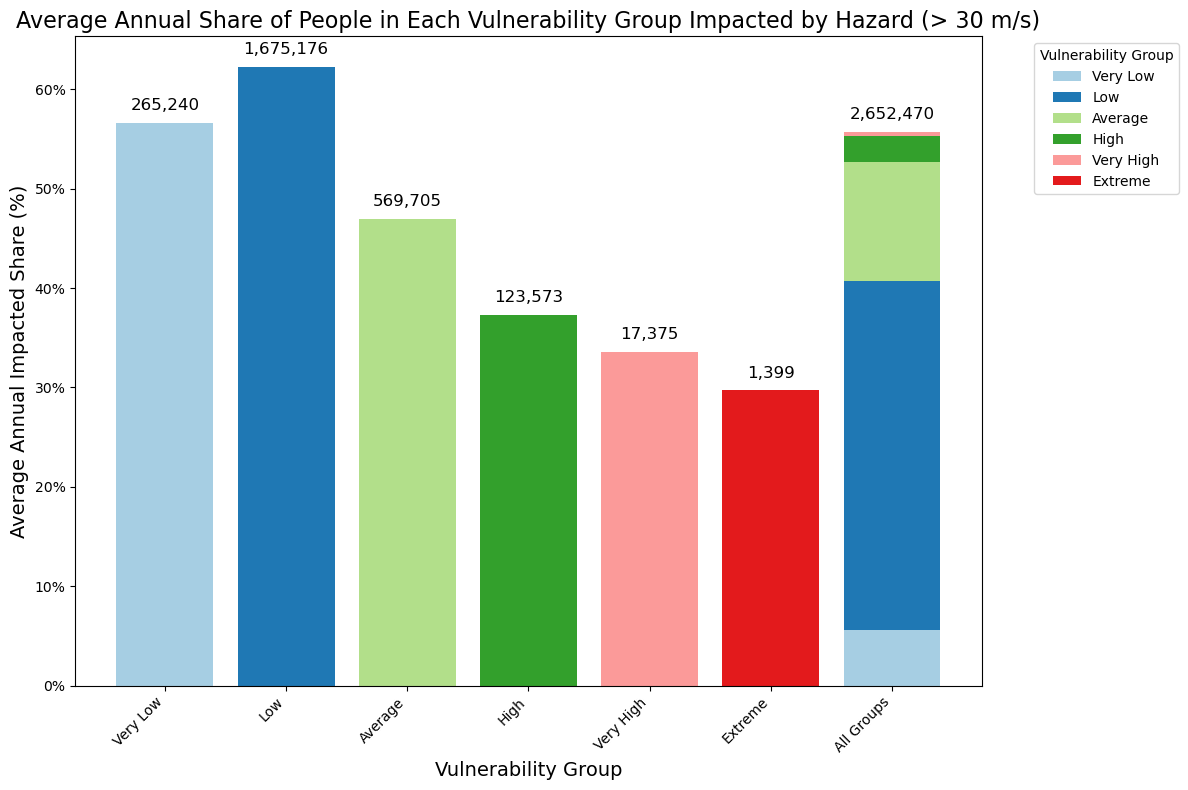

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store data for plotting
vuln_groups = []
impact_shares = []
total_people = []
aai_people = []

# Loop through each vulnerability group to calculate the share
for vuln_group, imp in imp_dict.items():
    if vuln_group == 'All':
        continue
    total_people_group = exp_dict[vuln_group].gdf['value'].sum()  # Total people in the group
    aai_people_group = imp_dict[vuln_group].aai_agg  # Expected number of people impacted per year in the group

    # Calculate the share of total people impacted in the group
    impact_share = aai_people_group / total_people_group

    # Append data to the lists
    vuln_groups.append(vuln_group)
    impact_shares.append(impact_share)
    total_people.append(total_people_group)
    aai_people.append(aai_people_group)

# Calculate total people and impacted people for the 'All' category
total_people_all = sum(total_people)
aai_people_all = sum(aai_people)
impact_share_all = aai_people_all / total_people_all

# Plotting
plt.figure(figsize=(12, 8))

# Plot individual bars for each vulnerability group
colors = plt.cm.Paired(np.arange(len(vuln_groups)))
bars = plt.bar(vuln_groups, impact_shares, color=colors)

# Plot stacked bar for 'All Groups' using the share of impacted people per group
bottom = 0
for i, color in enumerate(colors):
    group_share_of_all = aai_people[i] / total_people_all  # Contribution of each group to the total "All Groups" category
    plt.bar('All Groups', group_share_of_all, bottom=bottom, color=color)
    bottom += group_share_of_all

# Adding title and labels
plt.title(f"Average Annual Share of People in Each Vulnerability Group Impacted by Hazard (> {threshold1} m/s)", fontsize=16)
plt.xlabel("Vulnerability Group", fontsize=14)
plt.ylabel("Average Annual Impacted Share (%)", fontsize=14)

# Show percentage on y-axis
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

# Rotate x-axis labels if necessary
plt.xticks(rotation=45, ha='right')

# Add legend
plt.legend(bars, vuln_groups, title="Vulnerability Group", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add text annotations on top of each bar for individual vulnerability groups
for bar, impacted in zip(bars, aai_people):
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        yval + 0.01,  # Slightly above the bar
        f'{int(impacted):,}',  # Format number with comma separator
        ha='center', 
        va='bottom',
        fontsize=12
    )

# Add annotation for the 'All Groups' stacked bar
plt.text(
    len(vuln_groups),  # X position for "All Groups" (last index)
    impact_share_all + 0.01, 
    f'{int(aai_people_all):,}', 
    ha='center', 
    va='bottom',
    fontsize=12
)

# Display the plot
plt.tight_layout()
plt.show()


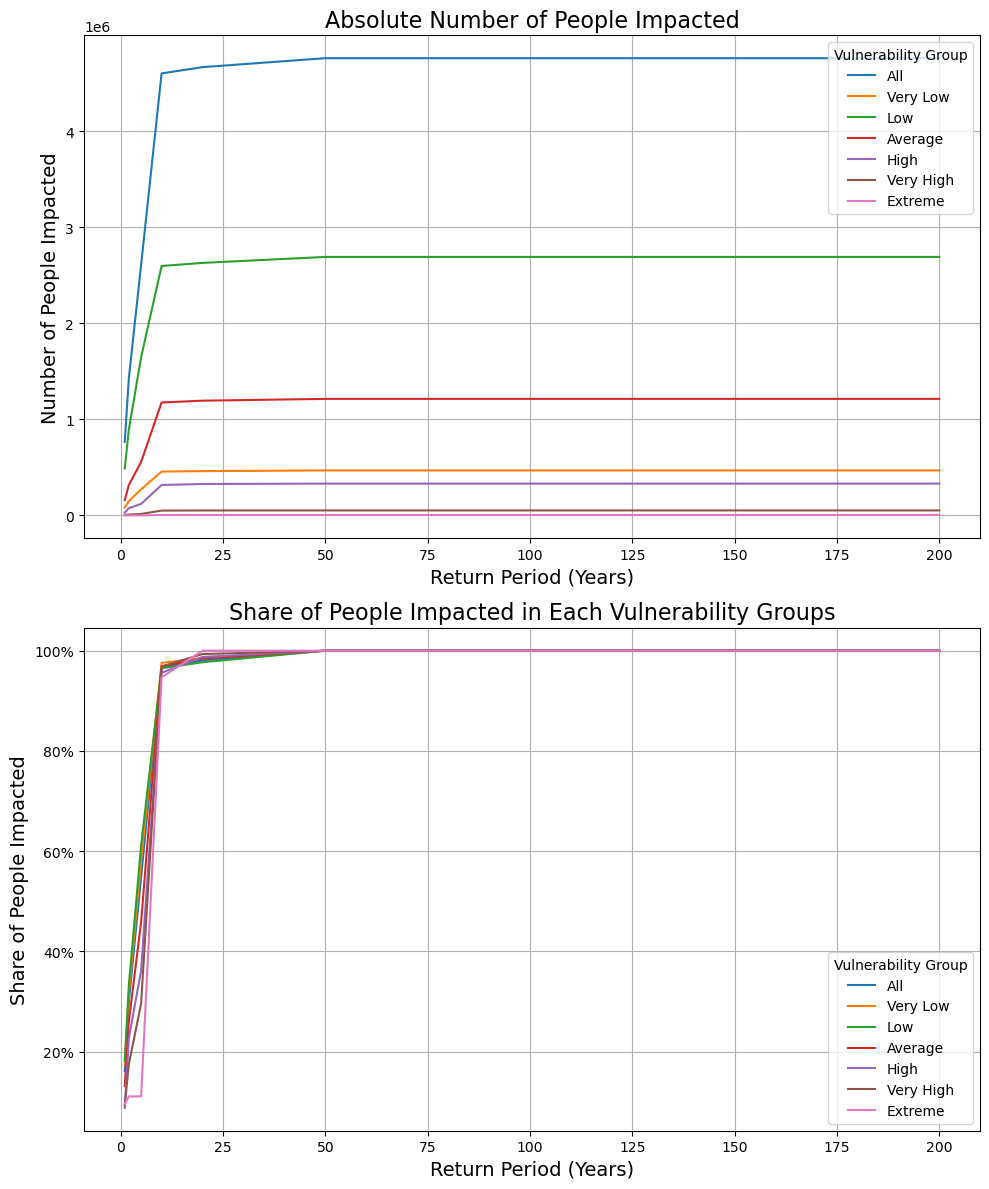

In [15]:
import matplotlib.pyplot as plt

# Define the return periods
return_per = [1, 2, 5, 10, 20, 50, 100, 200]
rp_dict = {}

# Loop through each vulnerability group to calculate and plot the frequency curve
for vuln_group, imp in imp_dict.items():
    rp_dict[vuln_group] = imp.calc_freq_curve(return_per=return_per)

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Loop through each vulnerability group to plot the return period curve
for vuln_group, rp_curve in rp_dict.items():
    # Get the total number of people in the group
    total_people_group = exp_dict[vuln_group].gdf['value'].sum()
    
    # Calculate the share of people impacted
    impact_share = rp_curve.impact / total_people_group
    
    # Plot the absolute number of people impacted
    ax1.plot(rp_curve.return_per, rp_curve.impact, label=vuln_group)
    
    # Plot the share of total people impacted
    ax2.plot(rp_curve.return_per, impact_share, label=vuln_group)

# Titles and labels for the absolute numbers plot
ax1.set_title("Absolute Number of People Impacted", fontsize=16)
ax1.set_xlabel("Return Period (Years)", fontsize=14)
ax1.set_ylabel("Number of People Impacted", fontsize=14)
ax1.legend(title="Vulnerability Group")
ax1.grid(True)

# Titles and labels for the share plot
ax2.set_title("Share of People Impacted in Each Vulnerability Groups", fontsize=16)
ax2.set_xlabel("Return Period (Years)", fontsize=14)
ax2.set_ylabel("Share of People Impacted", fontsize=14)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax2.legend(title="Vulnerability Group")
ax2.grid(True)

# Display both plots neatly
plt.tight_layout()
plt.show()
